In [48]:
from modules.metropolis import *
import numpy as np
import matplotlib.pyplot as plt

@dataclass
class SimpleProblem(QFTProblem):
    size: float = 10

    def volume(self) -> npt.NDArray:
        return np.array([10, 100]).reshape((1, 2))

    def get_amplitude(self, x_n: npt.NDArray) -> float:
        return np.exp(-x_n.shape[0] / 10) / np.power(np.prod(self.volume()), x_n.shape[0] / 2)

In [49]:
test_problem = SimpleProblem()

metropolis = FockSpaceMetropolis(test_problem, rng=np.random.default_rng())

x_n = metropolis.new_configuration(5)
print("initial\n", x_n)

x_add = metropolis.add_new(x_n)
print("add new\n", x_add)

x_remove = metropolis.remove_one(x_n)
print("remove one\n", x_remove)
            
x_changed = metropolis.change_positions(x_n)
print("change position\n", x_changed)

x_changed = metropolis.change_positions(x_n)
print("change position\n", x_changed)

x_n = metropolis.new_configuration(0)
print("initial\n", x_n)

x_remove = metropolis.remove_one(x_n)
print("remove one\n", x_remove)

x_add = metropolis.add_new(x_n)
print("add new\n", x_add)

initial
 [[ 7.02308357 41.59575417]
 [ 6.10468547 94.38894923]
 [ 3.76295922 46.70399041]
 [ 3.48137737 27.4955055 ]
 [ 2.23479484 79.4222231 ]]
add new
 [[ 7.02308357 41.59575417]
 [ 6.10468547 94.38894923]
 [ 3.76295922 46.70399041]
 [ 3.48137737 27.4955055 ]
 [ 2.23479484 79.4222231 ]
 [ 8.7016528  30.11075798]]
remove one
 [[ 6.10468547 94.38894923]
 [ 3.76295922 46.70399041]
 [ 3.48137737 27.4955055 ]
 [ 2.23479484 79.4222231 ]]
change position
 [[10.         23.35143279]
 [ 3.6528353  73.72546896]
 [ 0.         27.30692529]
 [ 6.14420297 72.57653536]
 [ 1.74949139 68.75111223]]
change position
 [[ 8.0852019  64.47234273]
 [ 2.65741666 91.19639796]
 [ 0.79088883 27.48807334]
 [ 6.78805003  0.70810693]
 [ 6.91372795 67.79964696]]
initial
 []
remove one
 None
add new
 [[ 7.00572692 54.29354415]]


In [52]:
x_recent = metropolis.new_configuration(5)
configurations = [x_recent]
for _ in range(10000):
    result = metropolis.step(x_recent)
    if result is None:
        continue

    x_recent = result
    configurations.append(x_recent)

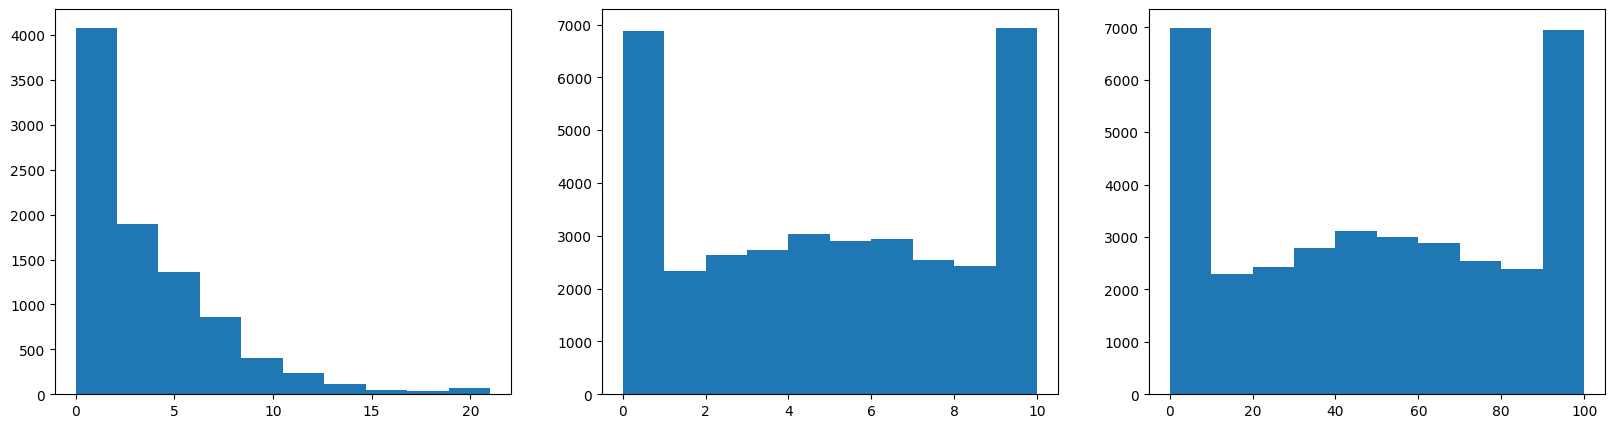

In [53]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

n_values = list(map(lambda x: x.shape[0], configurations))
axes[0].hist(n_values) # type: ignore

positions_1 = np.concatenate(list(map(lambda x: x[:, 0], configurations))).ravel()
positions_2 = np.concatenate(list(map(lambda x: x[:, 1], configurations))).ravel()

axes[1].hist(positions_1) # type: ignore
axes[2].hist(positions_2); # type: ignore